# Rozpoznawanie ras psów z wykorzystaniem biblioteki Keras
### Michał Foryt, Szczepan Gabiec, Paweł Wróblewski

<img src="meme2.jpg" style="width: 400px;">

Celem projektu jest stworzenie algorytmu służącego do rozpoznawaniu ras psów porzy wykorzystaniu biblioteki Keras, w oparciu o TensorFlow. Zbiór z którego korzystaliśmy pochodzi z jednego z konkursów zorganizowanych przez portal Kaggle i znajduje się pod tym linkiem: https://www.kaggle.com/c/dog-breed-identification. Z uwagi na jego rozmiar (~750MB) nie bedzie on dołączony bezpośrednio do kodu.  

W skład zbioru wchodzi około 10 tysięcy zdjęć, a wśród nich można wyróźnić 120 klas (ras psów). Pracując na tych danych, będziemy mogli stworzyć algorytm bazujący na głębokim uczeniu sieci neuronowych. W dużym uproszczeniu, zadaniem tego typu algorytmu jest rozpoznawanie obrazów podobnie, jak robi to umysł ludzki - "oglądając" ogromną pulę zdjęć z czasem rozpoznaje charakterystyczne cechy dla danego obiektu, przykładowo że rottweilera można poznać po tym, że jest duży i ma krótką, ciemną sierść, a york ma krótkie łapy i jest mocno owłosiony. Innymi słowy, algorytm najpierw zbiera dużą ilość danych, a następnie pozwala komputerowi zapoznać się z każdym z nich. Opierając się na dużych bazach danych i zauważając pojawiające się wzorce, komputery mogą rozpoznać obrazy i sformułować odpowiednie tagi i kategorie.

Formalnie można nakreślić następujacy przebieg metody:
- Na wejściu algorytm otrzymuje zbiór zawierający N obrazów, każdy z nich przypisany jest do jednej z K klas. 
- Następnie wykorzystuje się zbiór treningowy do szkolenia klasyfikatora tak, aby był on w stanie jak najepiej przyporządkować etykietę do zdjęcia.
- Na koniec ocenia się jakość klasyfikatora, prosząc go o przewidywanie etykiet dla nowego zestawu obrazów, których nigdy wcześniej nie widział, po czym porównamy prawdziwe etykiety tych obrazów z przewidywanymi przez klasyfikator.


## Konwolucyjne Sieci Neuronowe 
Konwolucyjne Sieci Neuronowe (ang. <i>CNN, Convolutional neural networks</i>, tłumaczone także jako <i>Splotowe Sieci Neuronowe</i>) w sprytny sposób redukują liczbę przyjmowanych parametrów. Zamiast działać na sieci, w której neurony są połączone każdy z każdym, podejście jakie prezentują CNN wykorzystują wielokrotnie te same parametry. Kluczem do sukcesu konwolucyjnych sieci jest fakt, że wychodza one z założenia, że wystarczy lokalne zrozumienie obrazu. Innymi słowy, algorytm skupia się na tym, by  stopniowo filtrować różne części danych uczących i wyostrzać ważne cechy w procesie dyskryminacji wykorzystanym do rozpoznawania lub klasyfikacji wzorców. W praktyce zaletą takiego podejścia jest posiadanie mniejszej liczby parametrów, co przekłada się na znaczne zmniejszenie czasu potrzebnego do wytrenowania modelu.

Rozważmy obraz o wymiarze 256 × 256 pikseli. Zamiast przetwarzać cały obraz naraz, CNN może skutecznie skanować go po kawałku - powiedzmy, patrząc na fragment o wymiarach 5 × 5. Taka ramka o wymiarach 5 × 5px przesuwa się wzdłuż obrazu (zwykle od lewej do prawej i od góry do dołu), jak pokazano na poniższym rysunku. 

<img src="cnn_concept.jpeg" style="width: 350px;">

Tempo przesuwania się takiej ramki nazywamy "długością kroku". Na przykład długość kroku 2 oznacza, że okno 5 × 5 przesuwa się o 2 piksele na raz, aż obejmie cały obraz. Taka ramka 5 x 5 pikseli przekłada się na macierz wag o wymiarze 5 x 5. 

Tego typu operacja ma miejsce w warstwie konwolucyjnej sieci neuronowej. Typowa CNN posiada wiele tego typu warste. Każda z nich zazwyczaj generuje wiele różnych splotów (ang. <i>convolutions</i>). Co za tym idzie, macierz wagowa takiego tensora (czyli obiektu matematycznego będącego uogólnieniem pojęcia wektora) ma wymiary 5 × 5 x n, gdzie n liczbą konwolucji (splotów).

Przykładowo, załóżmy że przepuszczamy rozważany obraz przez pojedynczą warstwę splotu jako macierz wagowa 5 x 5 x 64 z ramką 5 x 5. Co za ty idzie, taki model posiada 5 x 5 x64 = 1600 parametrów, podczas gdy pełna sieć dla obrazu 256 x 256px wymagałaby zastosowania 65 536 parametrów.

## Obróbka zbioru danych
Jak już wspomnielismy na początku, wykorzystamy zbiór danych dotyczący rozpoznawania ras psów, który wstępnie został już podzielony na zbiór treningowy i testowy. Nazwa każdego z obrazów jest też jednocześnie jego unikalnym id. Cały zestaw danych zawiera zdjęcia 120 ras, jednak dla urposzczenia modelu przyjmiemy założenie, że ograniczamy się jedynie do rozpoznawania 8 najpopularniejszych.

Dla porządku, wszystkie niezbędne importy zastosujemy poniżej. Dzięki temu uzyskamy większa czytelność oraz podcas tworzenia naszej funkcjonalności będziemy mieli pewność, że wszystkie niezbędne paczki zostały już ściągnięte.  

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import pandas as pd
import math
import os
import scipy.misc
import time
import pickle
import pandas as pd 

from datetime import timedelta
from scipy.stats import itemfreq
from random import sample
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Otwarcie plików ZIP
from zipfile import ZipFile
from io import BytesIO

# Obróbka zdjęć
import PIL.Image
from IPython.display import display

Następnie rozpakowujemy dane testowe i treningowe.

In [8]:
archive_test = ZipFile("dataset/test.zip", 'r')
archive_train = ZipFile("dataset/train.zip", 'r')

Sprawdzamy czy dane zostały zaczytane poprawnie.

In [4]:
archive_train.namelist()[0:5]

['train/',
 'train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'train/0042188c895a2f14ef64a918ed9c7b64.jpg',
 'train/00ba244566e36e0af3d979320fd3017f.jpg',
 'train/00f34ac0a16ef43e6fd1de49a26081ce.jpg']

Piszemy funkcję której zadaniem jest stworzenie Pickle files. Tego typu pliki wykorzystuje się do serializacji i de-serializacji obiektów w Pythonie. Każdy plik można poddać "marynowaniu" ("piklowaniu"), aby można go było zapisać na dysku. Pickling jest metodą która umożliwia serializację obiektu przed zapisaniem go do pliku. Pozwala zapisać obiekt pythonowy jako strumień znaków. Taka konstrukcja zawiera wszystkie informacje niezbędne do zrekonstruowania obiektu w innym skrypcie Pythona.

In [70]:
def data_base_creator(archivezip, nwidth, nheight, save_name):
    # Przygotowujemy pustą macierz zerową do której zapisywać będziemy dane o poszczególnych pikselach. 
    # Każdy obiekt w tablicy allImages zawiera listę pikseli, a każdy piksel reprezentowany jest przez
    #listę 3-elementową, odpowiadającą wartości RGB
    allImages = np.zeros((len(archivezip.namelist()[:])-1, nwidth, nheight, 3))

    #Otwieramy każdy z obrazów, dostosowujemy rozmiar i zapisujemy 
    for i in range(1,len(archivezip.namelist()[:])):
        filename = BytesIO(archivezip.read(archivezip.namelist()[i]))
        image = PIL.Image.open(filename)
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image/255.0, 0.0, 1.0) # 255 = Maksymalna wartość w skali RGB dla piksela
        allImages[i-1]=image
    
    # Zapisujemy nowo utworzoną bazę danych
    pickle.dump(allImages, open( save_name + '.p', "wb" ))
    print("Done.")

Nastepnie definiujemy docelowy rozmiar zdjeć, po czym uruchamiamy stworzoną funkcję do normalizacji ich wymiarów, zarówno dla zbioru testowego jak i walidacyjnego.

In [33]:
image_resize = 60
data_base_creator(archivezip = archive_test, nwidth = image_resize, nheight = image_resize, save_name = "test")
data_base_creator(archivezip = archive_train, nwidth = image_resize, nheight = image_resize, save_name = "train")

Done.
Done.


Uzyskaliśmy w ten sposób odpowiednio przygotowany zbiór treningowy i testowy. Dzięki temu zabiegowi, jeśli będziemy potrzebować jednego z tych zbiorów, wystarczy bezpośrednio wywołać je poniższą komendą, zamiast za każdym razem wykonywać powyższy kod podczas kolejnych uruchomień. 

In [35]:
test = pickle.load(open("test.p", "rb"))
test.shape

(10357, 60, 60, 3)

In [36]:
train = pickle.load(open("train.p", "rb"))
train.shape

(10222, 60, 60, 3)

In [55]:
display(train)

array([[[[0.56862745, 0.59215686, 0.34901961],
         [0.49019608, 0.5254902 , 0.30980392],
         [0.31372549, 0.34509804, 0.12156863],
         ...,
         [0.54117647, 0.5372549 , 0.34901961],
         [0.48627451, 0.50980392, 0.2745098 ],
         [0.51372549, 0.5372549 , 0.30196078]],

        [[0.48627451, 0.55686275, 0.32156863],
         [0.55686275, 0.62745098, 0.39215686],
         [0.50588235, 0.56078431, 0.32941176],
         ...,
         [0.4745098 , 0.47843137, 0.25490196],
         [0.55294118, 0.57254902, 0.35294118],
         [0.52156863, 0.58431373, 0.34117647]],

        [[0.54117647, 0.58431373, 0.35686275],
         [0.61960784, 0.69019608, 0.44705882],
         [0.43529412, 0.51372549, 0.2745098 ],
         ...,
         [0.61568627, 0.6627451 , 0.41960784],
         [0.5254902 , 0.58039216, 0.38823529],
         [0.29803922, 0.3372549 , 0.12941176]],

        ...,

        [[0.20392157, 0.13333333, 0.11764706],
         [0.4627451 , 0.53333333, 0.24313725]

Zanim przejdziemy do kolejnego kroku musimy zaimportować tabelę zawierającą etykiety oraz id zdjęć. 

In [66]:
labels = pd.read_csv("dataset/labels.csv") 
# Preview the first 5 lines of the loaded data 
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Wykorzystywane obrazy mają różne wymiary. W naszym modelu musimy zmienić ich rozmiar do tego samego kształtu. Używamy powszechnej praktyki, aby przekształcić je w kwadrat. Musimy również znormalizować nasz zestaw danych, dzieląc przez 255 wszystkie wartości pikseli. Nowe wartości pikseli będą w zakresie [0,1].

In [69]:
image_resize = 60
nwidth = image_resize
nheight = image_resize

# nwidth x nheight = number of features because images are nwidth x nheight pixels
s = (len(labels['breed']), nwidth, nheight,3) 
allImage = np.zeros(s)

i = 0
for f, breed in labels.values:
    image = PIL.Image.open('dataset/train/{}.jpg'.format(f))
    image = image.resize((nwidth, nheight))
    image = np.array(image)
    image = np.clip(image/255.0, 0.0, 1.0) # 255 = max of the value of a pixel
    i += 1
    allImage[i-1]=image

    train = allImage

Aby sprawdzić, czy obrazki wczytały się poprawnie, warto wyświetlić jeden z nich. 

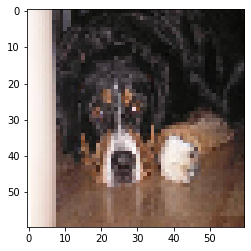

In [74]:
sample_img = train[200,:,:,:]
plt.imshow(sample_img)
plt.show()